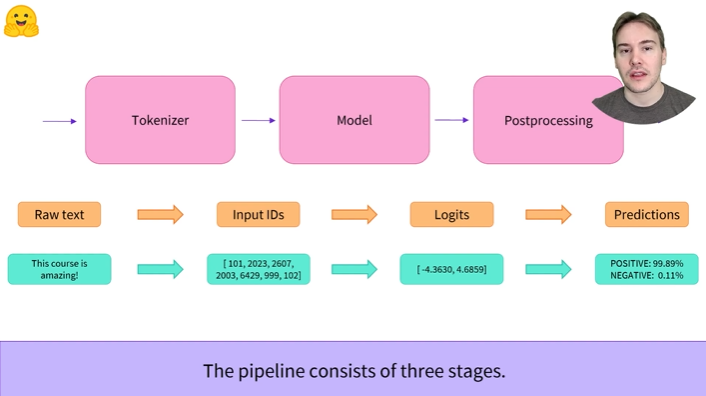

<font size=5> Tokenization Step Consists of following </font>

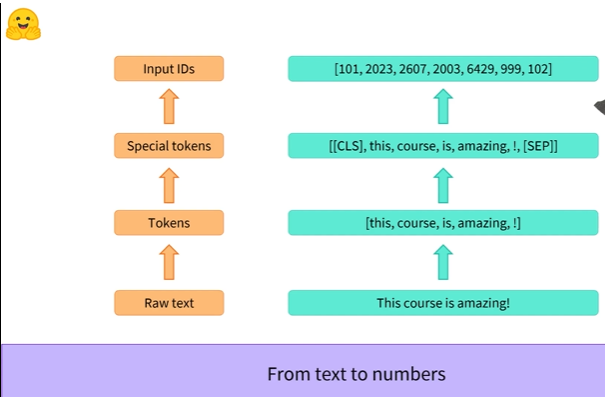

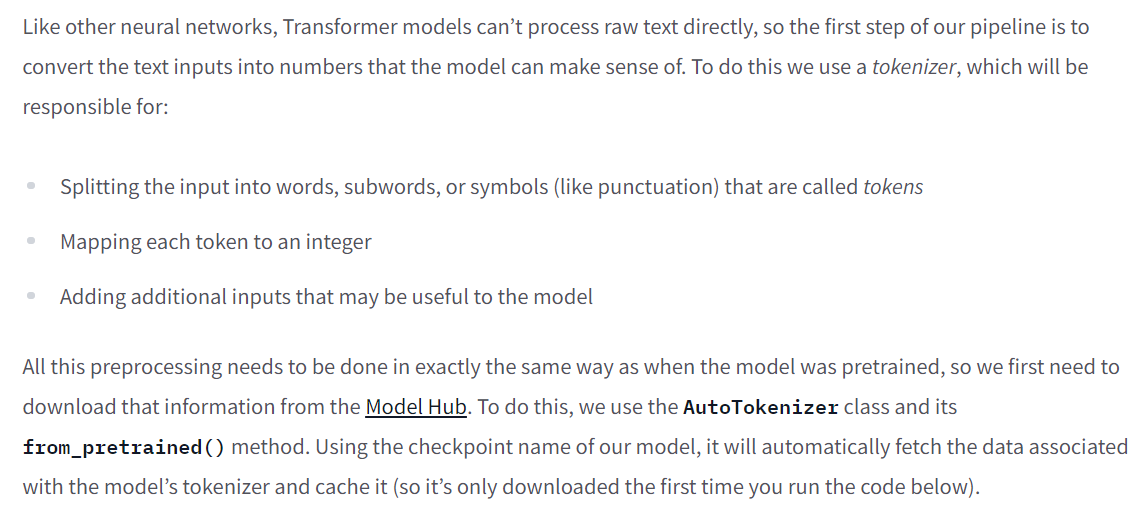

In [1]:
from transformers import AutoTokenizer

In [12]:
checkpoint = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [24]:
raw_inputs = ["I've been waiting for a HuggingFace course my whole life.",
              'I hate this so much'
             ]

In [25]:
inputs = tokenizer(raw_inputs)

In [36]:
inputs #this returns a list of list which when passed to the model will FAIL. Model expects tensor (pt or tf). 
## So use return_tensors argument

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

With additional arguments

In [27]:
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

<font size=3> Notice the extra zeros (padding) to the second sentence in the above code </font>

<font size=3> Truncation will truncate any sentence where the tokens are more than the max tokens of the model specified </font>

<font size=5> Stage 2 - Model </font>

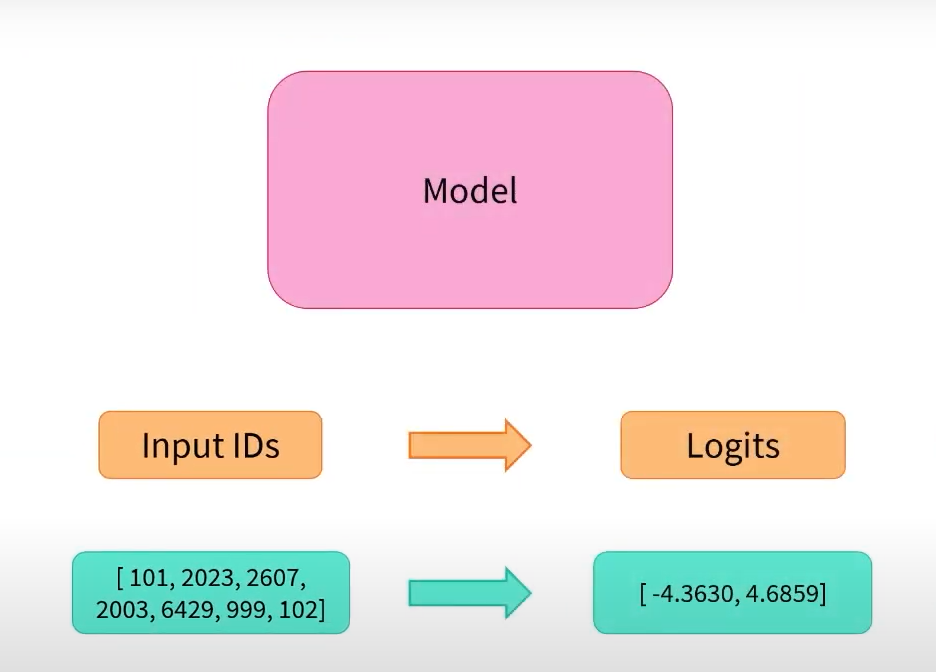

<font size=5> There is an AutoModel API which can be used to download the
1. **Model Configurations**
2. **Pretrained Weights of the model** </font>

<font size=4> This AutoModel API only instantiates the **body** of the model and **not the head** (the last output layer) used during the pretraining stage </font>

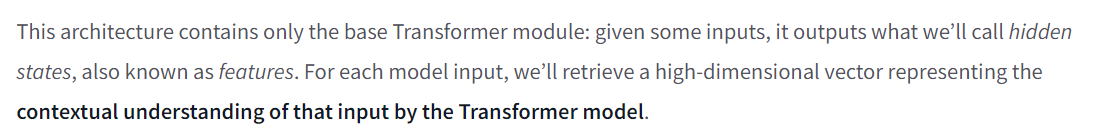

In [28]:
from transformers import AutoModel
# USE THE SAME CHECKPOINT AS TOKENIZER
model = AutoModel.from_pretrained(checkpoint)
outputs = model(**inputs)
outputs

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutput(last_hidden_state=tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
         [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
         [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
         ...,
         [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
         [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
         [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]],

        [[-0.3088,  0.7332, -0.1861,  ..., -0.1305, -0.9360, -0.0433],
         [-0.3340,  0.9830, -0.0946,  ..., -0.3825, -0.6176,  0.2008],
         [-0.1687,  0.8781, -0.1117,  ..., -0.2380, -0.7790,  0.0935],
         ...,
         [-0.3047,  0.7850, -0.2043,  ..., -0.1101, -0.7665, -0.0563],
         [-0.4014,  0.8999, -0.2245,  ..., -0.1877, -0.6910,  0.0329],
         [-0.2933,  0.7947, -0.2140,  ..., -0.1002, -0.7508, -0.0623]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [29]:
outputs.last_hidden_state.shape

torch.Size([2, 16, 768])

<font size=5> 2 sentences, max tokens of 16 (first sentence) and 768 dimension embeddings for each </font>

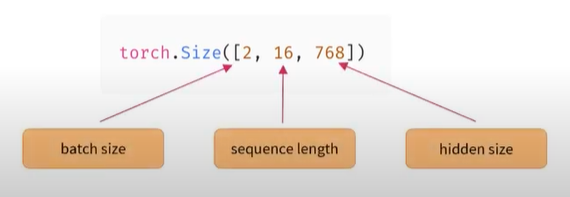

---------------------------------------------------------------------------------------------------------------------------
<font size=7> To get **with the head**
    
*the above model was used for classification </font>

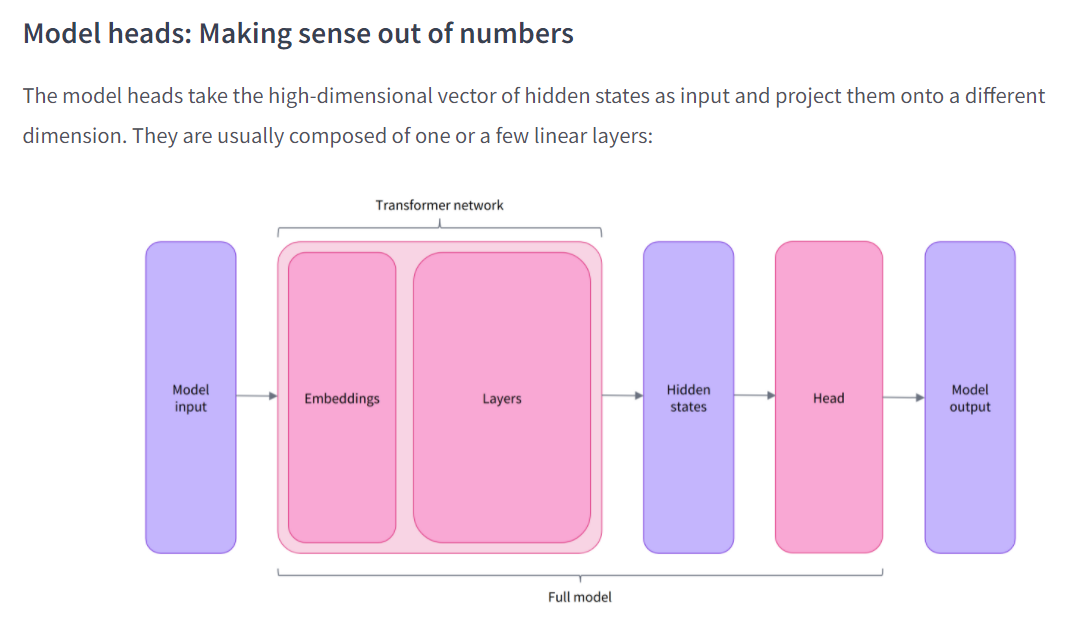

In [30]:
from transformers import AutoModelForSequenceClassification

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [ 4.2141, -3.4158]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [33]:
outputs.logits

tensor([[-1.5607,  1.6123],
        [ 4.2141, -3.4158]], grad_fn=<AddmmBackward0>)

<font size=5> Model with a head returns logits not porbabilites. To convert we need to do the last stage - Post Processing </font>

<font size=7> Stage 3 </font>

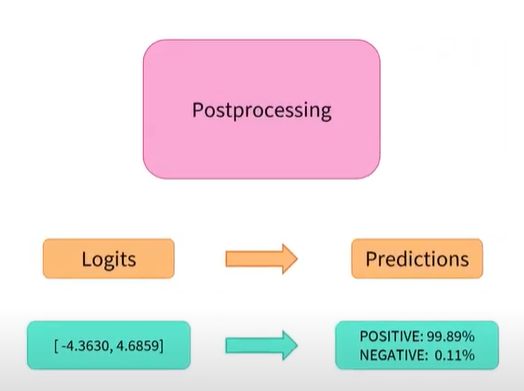

In [34]:
import torch
torch.nn.functional.softmax(outputs.logits, dim=-1)

tensor([[4.0195e-02, 9.5981e-01],
        [9.9951e-01, 4.8549e-04]], grad_fn=<SoftmaxBackward0>)

<font size=5> To know the label names </font>

In [35]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}